In [1]:
## Bendito - pg 75
# são agrupados de acordo com as suas características que condicionam o escoamento superficial e a erosão, como a profundidade, textura, 
# razão textural entre o horizonte superficial e subsuperficial, permeabilidade e porosidade (SARTORI; LOMBARDI NETO; GENOVEZ, 2005)
# A classificação hidrológica dos solos foi baseada na proposta de Sartori (2004) citado por Sartori; Lombardi Neto; Genovez (2005) para solos 
# do Brasil (Tabela 3 e Figura 3b). Quando os solos estão completamente molhados, o grupo A compreende os solos com baixo potencial de escoamento 
# e alta taxa de infiltração moderada taxa de infiltração, o grupo B compreende os solos contendo, o grupo C compreende os solos contendo baixa
# taxa de infiltração e o grupo D compreende os solos que possuem alto potencial de escoamento, tendo uma taxa de infiltração muito baixa. Para 
# tanto foi determinada a distribuição espacial dos atributos pedológicos da área de estudo utilizando-se do mapa pedológico do IBGE, com escala 
# espacial de 1:250.000 (IBGE, 2021).

# SARTORI, A.; LOMBARDI NETO, F.; GENOVEZ, A. M. Classificação Hidrológica de Solos Brasileiros para a Estimativa da Chuva Excedente com o 
# Método do Serviço de Conservação do Solo dos Estados Unidos Parte 1: Classificação. Revista Brasileira de Recursos Hídricos, v. 10, p. 5–18, 2005
## https://geoftp.ibge.gov.br/informacoes_ambientais/pedologia/vetores/escala_250_mil/versao_2023/

In [2]:
# Map of soil hydrologic groups. Pixels may have values 1, 2, 3, or 4, corresponding to soil hydrologic groups A, B, C, or D, respectively.

In [3]:
import pandas as pd
import geopandas as gpd
import tempfile
import os 
from osgeo import gdal, ogr
import numpy as np

In [4]:
bh = gpd.read_file("../bh_lago_paranoa.geojson").to_crs(4674)
bh = bh.to_crs(31983)
bh.geometry = bh.geometry.buffer(30)

In [5]:
pedo = gpd.read_file("pedo_area.shp").to_crs(31983)

<Axes: >

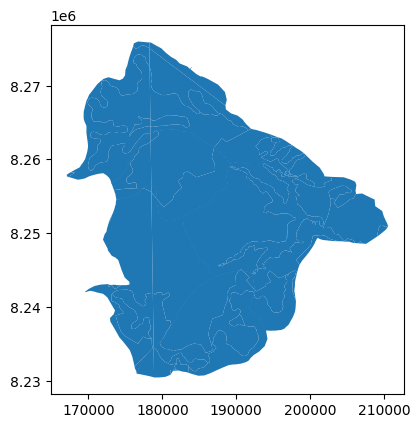

In [6]:
pedo_bh = gpd.overlay(bh[["geometry"]], pedo[["legenda", "textura", "geometry"]], how = "intersection")
pedo_bh.plot()

<Axes: >

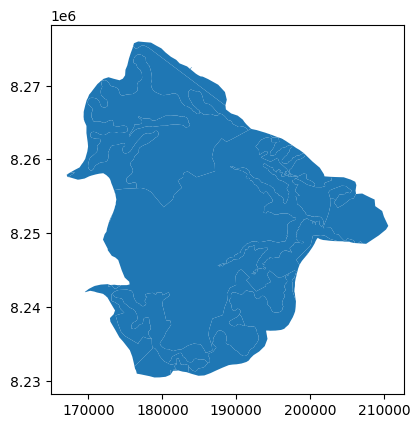

In [7]:
pedo_bh = pedo_bh.dissolve(by = ["legenda"]).reset_index()
pedo_bh.plot()

In [8]:
pedo_bh = pedo_bh.to_crs("EPSG:31983")
pedo_bh["area_ha"] = pedo_bh["geometry"].apply(lambda row: row.area/10_000)
pedo_bh = pedo_bh.to_crs("EPSG:4674")
pedo_bh

,legenda,geometry,textura,area_ha
0,CXbd - Cambissolo Háplico Tb Distrófico,"MULTIPOLYGON (((-47.93348 -15.96925, -47.93448...",média cascalhenta,4577.995617
1,Corpo d'água continental,"MULTIPOLYGON (((-47.87495 -15.85892, -47.87471...",None,4885.403264
2,LVAd - Latossolo Vermelho-Amarelo Distrófico,"MULTIPOLYGON (((-48.00047 -15.94791, -48.0015 ...",argilosa,26768.314414
3,LVd - Latossolo Vermelho Distrófico,"MULTIPOLYGON (((-48.01219 -15.98106, -48.01419...",argilosa e muito argilosa,18089.180562
4,LVw - Latossolo Vermelho Ácrico,"MULTIPOLYGON (((-47.76889 -15.76941, -47.76961...",argilosa e muito argilosa,2056.810156
5,RLd - Neossolo Litólico Distrófico,"POLYGON ((-47.91313 -15.66362, -47.91361 -15.6...",indiscriminada,653.587551
6,Área Urbana,"MULTIPOLYGON (((-47.96703 -15.9766, -47.9695 -...",None,49083.753381


In [9]:
pedo_bh['perc_area'] = 100*pedo_bh["area_ha"]/pedo_bh["area_ha"].sum()
pedo_bh[["legenda", "perc_area"]]. sort_values('perc_area', ascending = False)

,legenda,perc_area
6,Área Urbana,46.255226
2,LVAd - Latossolo Vermelho-Amarelo Distrófico,25.225749
3,LVd - Latossolo Vermelho Distrófico,17.046763
1,Corpo d'água continental,4.603874
0,CXbd - Cambissolo Háplico Tb Distrófico,4.314181
4,LVw - Latossolo Vermelho Ácrico,1.938283
5,RLd - Neossolo Litólico Distrófico,0.615924


In [15]:
pedo_bh['scs'] = pedo_bh.apply(
    lambda row: 'D' if 'Área Urbana' in row['legenda'] or 'Neossolo' in row['legenda']
    else ('C' if 'Cambissolo' in row['legenda'] 
          else ('A' if ('Latossolo' in row['legenda'] or "Corpo d'água" in row['legenda'])
                  else '')),
    axis=1
)

pedo_bh


,legenda,geometry,textura,area_ha,scs
0,CXbd - Cambissolo Háplico Tb Distrófico,"MULTIPOLYGON (((-47.93348 -15.96925, -47.93448...",média cascalhenta,4577.995617,C
1,Corpo d'água continental,"MULTIPOLYGON (((-47.87495 -15.85892, -47.87471...",None,4885.403264,A
2,LVAd - Latossolo Vermelho-Amarelo Distrófico,"MULTIPOLYGON (((-48.00047 -15.94791, -48.0015 ...",argilosa,26768.314414,A
3,LVd - Latossolo Vermelho Distrófico,"MULTIPOLYGON (((-48.01219 -15.98106, -48.01419...",argilosa e muito argilosa,18089.180562,A
4,LVw - Latossolo Vermelho Ácrico,"MULTIPOLYGON (((-47.76889 -15.76941, -47.76961...",argilosa e muito argilosa,2056.810156,A
5,RLd - Neossolo Litólico Distrófico,"POLYGON ((-47.91313 -15.66362, -47.91361 -15.6...",indiscriminada,653.587551,D
6,Área Urbana,"MULTIPOLYGON (((-47.96703 -15.9766, -47.9695 -...",None,49083.753381,D


In [16]:
pedo_bh['scs_value'] = pedo_bh['scs'].apply(
    lambda x: 1 if x == 'A' else (3 if x == 'C' else (4 if x == 'D' else ''))
)
pedo_bh

,legenda,geometry,textura,area_ha,scs,scs_value
0,CXbd - Cambissolo Háplico Tb Distrófico,"MULTIPOLYGON (((-47.93348 -15.96925, -47.93448...",média cascalhenta,4577.995617,C,3
1,Corpo d'água continental,"MULTIPOLYGON (((-47.87495 -15.85892, -47.87471...",None,4885.403264,A,1
2,LVAd - Latossolo Vermelho-Amarelo Distrófico,"MULTIPOLYGON (((-48.00047 -15.94791, -48.0015 ...",argilosa,26768.314414,A,1
3,LVd - Latossolo Vermelho Distrófico,"MULTIPOLYGON (((-48.01219 -15.98106, -48.01419...",argilosa e muito argilosa,18089.180562,A,1
4,LVw - Latossolo Vermelho Ácrico,"MULTIPOLYGON (((-47.76889 -15.76941, -47.76961...",argilosa e muito argilosa,2056.810156,A,1
5,RLd - Neossolo Litólico Distrófico,"POLYGON ((-47.91313 -15.66362, -47.91361 -15.6...",indiscriminada,653.587551,D,4
6,Área Urbana,"MULTIPOLYGON (((-47.96703 -15.9766, -47.9695 -...",None,49083.753381,D,4


In [22]:
pedo_bh.to_file("soil_group.geojson")

In [17]:
pedo_bh["solo_fmt"] = pedo_bh["legenda"].apply(
    lambda row: row.split(" - ")[-1].split(" ")[0] if ("Corpo d'água continental" not in row and "Área Urbana" not in row) else row
)

In [19]:
pedo_bh.to_file("soil_group_fmt.shp")

In [23]:
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_image
from functools import partial
from rasterio.enums import MergeAlg

def polygonsToRaster(gdf, column_band, output_file):

    gdf_raster = make_geocube(
        vector_data=gdf,
        measurements=[column_band],
        resolution=(-30, 30),
        fill = 0
    )
    gdf_raster.rio.to_raster(output_file)

In [25]:
pedo_bh = pedo_bh.to_crs(31983)
polygonsToRaster(pedo_bh, 'scs_value', "soil_group.tif")
pedo_bh = pedo_bh.to_crs(4674)

In [11]:
pedo_bh = gpd.read_file("soil_group.geojson")[["legenda", "scs"]].rename(columns = {"scs": "Grupo hidrológico USDA"})

In [16]:
pedo_bh["Solo"] = pedo_bh["legenda"].apply(lambda row: row.split(" - ")[-1])
pedo_bh["Unidade"] = pedo_bh["legenda"].apply(lambda row: row.split(" - ")[0])
pedo_bh["Unidade"] = pedo_bh["Unidade"].replace({"Área Urbana": " "})

In [18]:
pedo_bh[['Grupo hidrológico USDA', 'Solo', 'Unidade']].sort_values('Grupo hidrológico USDA')

,Grupo hidrológico USDA,Solo,Unidade
1,A,Corpo d'água continental,Corpo d'água continental
2,A,Latossolo Vermelho-Amarelo Distrófico,LVAd
3,A,Latossolo Vermelho Distrófico,LVd
4,A,Latossolo Vermelho Ácrico,LVw
0,C,Cambissolo Háplico Tb Distrófico,CXbd
5,D,Neossolo Litólico Distrófico,RLd
6,D,Área Urbana,


In [19]:
pedo_bh[['Grupo hidrológico USDA', 'Solo', 'Unidade']].sort_values('Grupo hidrológico USDA').to_excel("soil_group.xlsx", index = False)